In [2]:
# Loading data
relay_whs_path ='C:\\Users\\David\\Downloads\\RELAY_WHS.csv'
relay_df = pd.read_csv(relay_whs_path)

# Displaying the first few rows to inspect the structure
relay_df.head()


,IND_ID,IND_CODE,IND_UUID,IND_PER_CODE,DIM_TIME,DIM_TIME_TYPE,DIM_GEO_CODE_M49,DIM_GEO_CODE_TYPE,DIM_PUBLISH_STATE_CODE,IND_NAME,GEO_NAME_SHORT,DIM_SEX,RATE_PER_100_N,RATE_PER_100_NL,RATE_PER_100_NU
0,1F96863NCDMORT3070,NCDMORT3070,1F96863,NCDMORT3070,2000,YEAR,218,COUNTRY,PUBLISHED,Non-communicable diseases deaths (age 30 to 70),Ecuador,FEMALE,14.4,11.5,16.9
1,1F96863NCDMORT3070,NCDMORT3070,1F96863,NCDMORT3070,2000,YEAR,218,COUNTRY,PUBLISHED,Non-communicable diseases deaths (age 30 to 70),Ecuador,MALE,16.6,13.6,19.6
2,1F96863NCDMORT3070,NCDMORT3070,1F96863,NCDMORT3070,2000,YEAR,218,COUNTRY,PUBLISHED,Non-communicable diseases deaths (age 30 to 70),Ecuador,TOTAL,15.4,12.5,18.2
3,1F96863NCDMORT3070,NCDMORT3070,1F96863,NCDMORT3070,2000,YEAR,222,COUNTRY,PUBLISHED,Non-communicable diseases deaths (age 30 to 70),El Salvador,FEMALE,10.9,8.3,13.9
4,1F96863NCDMORT3070,NCDMORT3070,1F96863,NCDMORT3070,2000,YEAR,222,COUNTRY,PUBLISHED,Non-communicable diseases deaths (age 30 to 70),El Salvador,MALE,15.0,11.5,19.2


In [3]:
# Filtering for Rwanda
rwanda_ncd = relay_df[relay_df["GEO_NAME_SHORT"] == "Rwanda"]

# columns we need
rwanda_ncd = rwanda_ncd[["DIM_TIME", "DIM_SEX", "RATE_PER_100_N"]].rename(
    columns={"DIM_TIME": "Year", "DIM_SEX": "Gender", "RATE_PER_100_N": "NCD_Death_Rate"}
)

# Sort by year
rwanda_ncd = rwanda_ncd.sort_values(by=["Year", "Gender"]).reset_index(drop=True)

# Displaying the filtered dataset
rwanda_ncd.head(10)


,Year,Gender,NCD_Death_Rate
0,2000,FEMALE,34.7
1,2000,MALE,41.3
2,2000,TOTAL,37.6
3,2001,FEMALE,32.1
4,2001,MALE,38.1
5,2001,TOTAL,34.7
6,2002,FEMALE,29.5
7,2002,MALE,35.1
8,2002,TOTAL,31.8
9,2003,FEMALE,27.1


In [4]:
# Generating descriptive statistics
eda_summary = rwanda_ncd.groupby("Gender")["NCD_Death_Rate"].describe()

# Also, get overall stats
overall_stats = rwanda_ncd["NCD_Death_Rate"].describe()

eda_summary, overall_stats


(        count       mean       std   min     25%    50%     75%   max
 Gender                                                               
 FEMALE   22.0  21.968182  4.755587  18.1  18.925  19.60  22.925  34.7
 MALE     22.0  26.231818  5.585814  21.9  22.700  23.20  27.475  41.3
 TOTAL    22.0  23.759091  5.106174  20.0  20.525  21.05  24.800  37.6,
 count    66.000000
 mean     23.986364
 std       5.377099
 min      18.100000
 25%      20.425000
 50%      22.600000
 75%      25.475000
 max      41.300000
 Name: NCD_Death_Rate, dtype: float64)

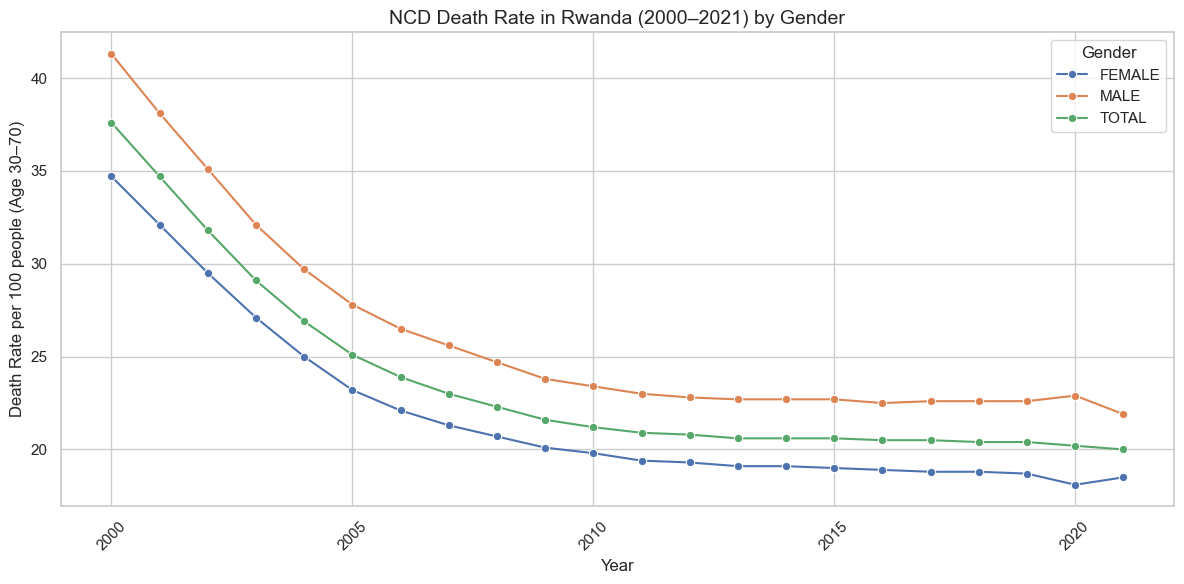

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Create a line plot of NCD death rate by year and gender
plt.figure(figsize=(12, 6))
sns.lineplot(data=rwanda_ncd, x="Year", y="NCD_Death_Rate", hue="Gender", marker="o")

# Add titles and labels
plt.title("NCD Death Rate in Rwanda (2000–2021) by Gender", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Death Rate per 100 people (Age 30–70)")
plt.legend(title="Gender")
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


In [7]:
# Re-import all required libraries due to kernel reset
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Reload dataset
relay_whs_path = "C:\\Users\\David\\Downloads\\RELAY_WHS.csv"
relay_df = pd.read_csv(relay_whs_path)

# Prepare Rwanda NCD mortality data
rwanda_ncd = relay_df[relay_df["GEO_NAME_SHORT"] == "Rwanda"]
rwanda_ncd = rwanda_ncd[["DIM_TIME", "DIM_SEX", "RATE_PER_100_N"]].rename(
    columns={"DIM_TIME": "Year", "DIM_SEX": "Gender", "RATE_PER_100_N": "NCD_Death_Rate"}
)

# Pivot table: rows = Year, columns = Gender
rwanda_pivot = rwanda_ncd.pivot(index="Year", columns="Gender", values="NCD_Death_Rate").dropna()

# Standardize data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(rwanda_pivot)

# Apply KMeans clustering with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_data)

# Assign cluster labels
rwanda_pivot["Cluster"] = cluster_labels

# Compute silhouette score
silhouette = silhouette_score(scaled_data, cluster_labels)

rwanda_pivot.reset_index(), silhouette


C:\Users\David\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


(Gender  Year  FEMALE  MALE  TOTAL  Cluster
 0       2000    34.7  41.3   37.6        1
 1       2001    32.1  38.1   34.7        1
 2       2002    29.5  35.1   31.8        2
 3       2003    27.1  32.1   29.1        2
 4       2004    25.0  29.7   26.9        2
 5       2005    23.2  27.8   25.1        0
 6       2006    22.1  26.5   23.9        0
 7       2007    21.3  25.6   23.0        0
 8       2008    20.7  24.7   22.3        0
 9       2009    20.1  23.8   21.6        0
 10      2010    19.8  23.4   21.2        0
 11      2011    19.4  23.0   20.9        0
 12      2012    19.3  22.8   20.8        0
 13      2013    19.1  22.7   20.6        0
 14      2014    19.1  22.7   20.6        0
 15      2015    19.0  22.7   20.6        0
 16      2016    18.9  22.5   20.5        0
 17      2017    18.8  22.6   20.5        0
 18      2018    18.8  22.6   20.4        0
 19      2019    18.7  22.6   20.4        0
 20      2020    18.1  22.9   20.2        0
 21      2021    18.5  21.9   20

In [9]:
# Add readable phase names to clusters
cluster_names = {
    0: "Low Risk Phase",
    1: "High Risk Phase",
    2: "Transition Phase"
}
rwanda_pivot["Phase"] = rwanda_pivot["Cluster"].map(cluster_names)

# Summary table: average death rates per cluster
cluster_summary = rwanda_pivot.groupby("Phase")[["FEMALE", "MALE", "TOTAL"]].mean()
print(cluster_summary)


Gender            FEMALE       MALE      TOTAL
Phase                                         
High Risk Phase     33.4  39.700000  36.150000
Low Risk Phase      19.7  23.576471  21.329412
Transition Phase    27.2  32.300000  29.266667


In [10]:
# Save CSV 
rwanda_pivot.reset_index().to_csv("rwanda_ncd_clustered.csv", index=False)
